## Gas flow through vent

When gas flows through an orifice, the maximum mass flow rate occurs under choked flow conditions (when the flow speed at the orifice "throat" is equal to the local speed of sound). For an ideal gas, if the upstream pressure is $P_1$ and the throat pressure is $P^*$, and $\gamma$ denotes the specific heat ratio of the gas, then the choked-flow pressure ratio can be calculated as:

$
\begin{align*}
\frac{P^*}{P_1} = \left(\frac{2}{\gamma+1}\right)^{\frac{\gamma}{\gamma - 1}}
\end{align*}
$

From there, assuming isentropic expansion, it is straightforward to calculate the temperature, density and local speed of sound, and hence the mass flux. This pressure ratio will typically be in the neighbourhood of 0.5, so given that the vapour pressure of nitrous oxide in the flight tank is at least thirty times higher than atmospheric pressure, it is clearly reasonable to assume choked flow across the vent orifice.

For a significantly non-ideal gas, such as nitrous oxide near its critical point, this approach results in some level of error. Fortunately, the thermodynamics library [CoolProp](http://www.coolprop.org/index.html) makes it straightforward to calculate choked flow conditions for a real gas.

Assuming isentropic expansion, the sonic conditions for a real gas can be found thus: let $P_1$, $s_1$, $T_1$ and $u_1$ denote the upstream pressure, specific entropy, temperature, and specific internal energy respectively, and $P^*$, $s^*$, $T^*$ and $u^*$ denote the same quantities at the sonic point, with $c^*$ and $\rho^*$ denoting the speed of sound and density at the choke point. Then we simply need to use CoolProp to search for a thermodynamic state (such as $(P^*, T^*)$) satisfying the following two conditions:

* $s_1 = s^*$
* Assuming that all of the "lost" specific internal energy is converted into kinetic energy, if $v$ denotes the flow speed at the sonic point, then we have $u_0 = u^* + \frac{v^2}{2}$. Hence the second condition is $\sqrt{2(u_0 - u^*)} = c^*$.

The mass flux (mass flow rate per square metre of orifice area) is then simply $\rho^*c^*$.

If the gas flow is likely to get significantly warmed by the orifice and other vent hardware components, then it may be closer to an isothermal process. It is relatively straightforward to adjust this model for isothermal expansion instead of isentropic expansion, if desired.

Some example code below that does this for saturated nitrous oxide vapour:

Populating the interactive namespace from numpy and matplotlib
Sanity check: predicted mass flow rate through ⌀0.5 mm orifice at 33 bar with C_d = 0.7 is 1.405 grams/second


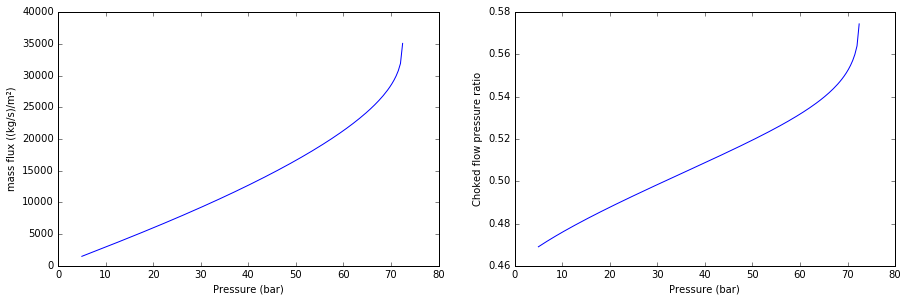

In [2]:
import numpy as np
import scipy.optimize as spopt
import CoolProp.CoolProp as cp
import matplotlib.pyplot as plt
%pylab inline

## some more-readable wrappers for CoolProp functions
# 'Q' means 'quality' - the mass fraction of a saturated mixture which is vapour.
# Here Q=0 means "liquid phase" and Q=1 means "gas phase".
def satPressure(T, fluidName):
    return cp.PropsSI('P', 'T', T, 'Q', 1, fluidName)

def satGasSpecEnthalpy(T, fluidName): #J/kg
    return cp.PropsSI('H', 'T', T, 'Q', 1, fluidName)    

def satGasDensity(T, fluidName):
    return cp.PropsSI('D', 'T', T, 'Q', 1, fluidName)

def satGasSpecIntEnergy(T, fluidName):
    specVol=1/satGasDensity(T, fluidName) #1/density
    vapPress=satPressure(T, fluidName)
    return satGasSpecEnthalpy(T, fluidName)-specVol*vapPress

def flowSpeedFromSaturatedVapour(P1, S1, P_star, fluidName):
    T1 = cp.PropsSI('T', 'P', P1, 'Q', 1, fluidName) # this is unnecessary but lets me reuse the above three wrappers
    
    u_0 = satGasSpecIntEnergy(T1, fluidName)
    
    h_star = cp.PropsSI('H', 'P', P_star, 'S', S1, fluidName) # specific internal enthalpy at throat
    rho_star = cp.PropsSI('D', 'P', P_star, 'S', S1, fluidName) # density at throat
    u_star = h_star - P_star/rho_star # internal energy is internal enthalpy minus pressure-times-volume energy
    
    return np.sqrt(2*(u_0 - u_star))

# Used for root-finding. "Excess Mach" of 0.01 = Mach number of 1.01. This isn't a standard name.
def localExcessMachFromSaturatedVapour(P_star, S1, P1, fluidName):
    flow_speed = flowSpeedFromSaturatedVapour(P1, S1, P_star, fluidName)
    local_sonic_speed = cp.PropsSI('SPEED_OF_SOUND', 'P', P_star, 'S', S1, fluidName)    
    return flow_speed/local_sonic_speed - 1

def chokingPressureFromSaturatedVapour(P1, fluidName):
    S1 = cp.PropsSI('S', 'P', P1, 'Q', 1, fluidName)

    argList = (S1, P1, fluidName) # fsolve only looks at one parameter, needs a list of the others

    root = spopt.fsolve(localExcessMachFromSaturatedVapour, P1/2, args = argList)
    return root[0]

def chokedMassFluxFromSaturatedVapour(P1, fluidName):
    S1 = cp.PropsSI('S', 'P', P1, 'Q', 1, fluidName)
    P_star = chokingPressureFromSaturatedVapour(P1, fluidName)
    
    c_star = cp.PropsSI('SPEED_OF_SOUND', 'P', P_star, 'S', S1, fluidName)
    rho_star = cp.PropsSI('D', 'P', P_star, 'S', S1, fluidName)
    m_flux = c_star*rho_star # mass per unit area of orifice, (kg/s)/m²
    
    return m_flux, P_star

pressures = np.linspace(5e5, cp.PropsSI('PCRIT','NitrousOxide'),num=150)
massFluxes = np.zeros_like(pressures)
pressureRatios = np.zeros_like(pressures)

for i, pressure in enumerate(pressures):
    massFluxes[i], pressureRatios[i] = chokedMassFluxFromSaturatedVapour(pressure, 'NitrousOxide')
    pressureRatios[i]/=pressure
    
massFluxAt33 = chokedMassFluxFromSaturatedVapour(33e5, 'NitrousOxide')[0]
sanCheckVal = 0.7*np.pi*(0.00025**2)*massFluxAt33
print("Sanity check: predicted mass flow rate through ⌀0.5 mm orifice at 33 bar with C_d = 0.7 is {:.3f} grams/second".format(sanCheckVal*1000))
    
figsize(15,10)

fig=plt.figure()

sp1=fig.add_subplot(221)
sp1.plot(pressures/1e5,massFluxes)
sp1.set_xlabel("Pressure (bar)")
sp1.set_ylabel("mass flux ((kg/s)/m²)")

sp2=fig.add_subplot(222)
sp2.plot(pressures/1e5,pressureRatios)
sp2.set_xlabel("Pressure (bar)")
sp2.set_ylabel("Choked flow pressure ratio")

As expected, the mass flux is approximately linear with pressure for low pressures, where the ideal gas approximation is reasonable, but departs markedly from this as we approach the critical point. Note also the change in choking pressure ratio from 0.47 to 0.58 as the pressure increases - this corresponds to the effective gamma for this process changing from ~1.79 to ~1.12, a fairly significant variation. 

## Tank physics

Modelling self-pressurised nitrous oxide can be fairly complicated. See the AspireSpace paper [The Physics of Nitrous Oxide](http://aspirespace.org.uk/downloads/The%20physics%20of%20nitrous%20oxide.pdf) for a quick introduction, and [Modelling the Nitrous Run Tank Emptying](http://aspirespace.org.uk/downloads/Modelling%20the%20nitrous%20run%20tank%20emptying.pdf) for an application of this to hybrid rocket motors.

The approach taken for this analysis is based on the equilibrium model presented in Zimmerman et al's paper [Review and Evaluation of Models for
Self-Pressurizing Propellant Tank Dynamics](https://web.stanford.edu/~cantwell/Recent_publications/Zimmerman_et_al_AIAA_2013-4045.pdf), with some extra simplifications and omissions. I believe this is more or less equivalent to the model presented in the second Aspire paper above by Rick (albeit not coupled to a combustion chamber model).

The nitrous oxide tank is modelled as a two-node equilibrium system: that is, we consider only the properties of the gaseous component and the liquid component as lumped parameters; we also assume that they have equal temperature and pressure, and are always at saturation (the liquid's temperature is such that its vapor pressure is equal to the pressure in the tank). It is assumed that as the liquid phase drains out and the pressure drops, some of the liquid boils instantly to replenish the lost gas, and that the entire tank hence remains in equlibrium. Heat flow into and out of the run tank is neglected - for slow-filling tanks this assumption may need to be revisited.

Two state variables are used in this model: the total mass of fluid in the tank $m_{tot}$ and the total internal energy of the tank $U_{tot}$. This latter is equal to the product of pressure and volume of the tank, plus the sum of the enthalpies of the liquid and gas phase. This model actually makes the differential equations very simple: if we know the mass flow out of the tank and whether it's the liquid or gas phase, then the rate of change of internal energy is simply the mass flow times the specific internal energy of that phase. In other words:

$\dfrac{dm_{tot}}{dt} = \dot{m}$

$\dfrac{dU_{tot}}{dt} =     \begin{cases}
      \dot{m}{u_{\text{liq}}} & \text{for outflowing liquid} \\
      \dot{m}{u_{\text{vap}}} & \text{for outflowing vapor}
    \end{cases}$

where $\dot{m}$ is a placeholder for the mass flow rate into the fill orifice or out of the vent.

From the mass and total internal energy, and using the assumption that the nitrous oxide is at saturation, it is possible to calculate the fraction of mass which is vapour:

$\begin{align}
m_{f (vapour)} = \dfrac{\frac{U_{tot}}{m_{tot}} - u_{liq}}{u_{vap}-u_{liq}} \end{align}$

where $u_{liq}$ and $u_{vap}$ are the specific internal energies of the liquid and gaseous phases respectively, and can be calculated by CoolProp using from the current temperature.

Similarly, given $U_{tot}$, $m_{tot}$, $T$ and $m_{f (vapour)}$, we can calculate the total tank volume.

$\begin{align}
V_{tank} = m_{tot}\left(\frac{1-m_{f (vapour)}}{\rho_{liq}} + \frac{m_{f (vapour)}}{\rho_{vap}} \right)
\end{align}$

where $\rho_{liq}$ and $\rho_{vap}$ can be calculated by CoolProp under the saturation assumption and the current fluid temperature $T$.

Unfortunately, at this point, we must resort to numerical methods to calculate $T$. In particular, since $V_{tank}$ is a known (constant) value at any given time, we can iteratively solve the equation above to find a temperature at which the calculated tank volume matches the known tank volume. This is done in the code below in the ``findTemp`` function.

In [3]:
## more more-readable wrappers for CoolProp functions
def satLiquidDensity(T, fluidName):
    return cp.PropsSI('D', 'T', T, 'Q', 0, fluidName) 

def satLiquidSpecEnthalpy(T, fluidName): #J/kg
    return cp.PropsSI('H', 'T', T, 'Q', 0, fluidName)

def satLiquidSpecIntEnergy(T, fluidName):
    specVol=1/satLiquidDensity(T, fluidName) #1/density
    vapPress=satPressure(T, fluidName)
    return satLiquidSpecEnthalpy(T, fluidName)-specVol*vapPress

## equilibrium-model-specific helpers
def vaporMassFraction(Utot, mtot, T, fluidName):
    u_vap=satGasSpecIntEnergy(T, fluidName)
    u_liq=satLiquidSpecIntEnergy(T, fluidName)
    
    return (Utot/mtot-u_liq)/(u_vap-u_liq)

def vaporMass(Utot,mtot,T, fluidName):
    return mtot*vaporMassFraction(Utot,mtot,T, fluidName)

def liquidMass(Utot,mtot,T, fluidName):
    return mtot-vaporMass(Utot,mtot,T, fluidName)

# Tank volume required to contain a given mass of saturated fluid at temperature T and total internal energy Utot.
# Basically just inverse of density.
def VTank(T,Utot,mtot,fluidName, vTarget = 0):
    x = vaporMassFraction(Utot,mtot,T, fluidName)
    
    rho_liq = satLiquidDensity(T, fluidName)
    rho_gas=satGasDensity(T, fluidName)
    
    return mtot*((1-x)/rho_liq+x/rho_gas) - vTarget # vTarget (target volume), is used for root-finding

def findTemp(mtot,Utot,V_tank,fluidName,P_guess=1e6):   
    # The pressure guess isn't used beyond this point - its only purpose is to make a reasonable initial guess of T.
    T_guess = cp.PropsSI('T', 'P', P_guess, 'Q', 0, fluidName)
    
    arglist = (Utot, mtot, fluidName, V_tank) 
    
    return spopt.fsolve(VTank,T_guess,args = arglist)[0]
    
def tempFromSatPressure(P,fluidName):   
    return cp.PropsSI('T', 'P', P, 'Q', 0, fluidName)

In this scenario we actually model two coupled nitrous oxide tanks: a ground tank transferring liquid into the flight tank through the fill orifice, and a flight tank venting gas through the vent orifice. Under the assumption that the ground tank only ever fills the flight tank with liquid, and the flight tank only ever vents gas, then the ODE is:

$\dfrac{dm_{tot \text{(ground)}}}{dt} = - \dot{m}_{fill}$

$\dfrac{dm_{tot \text{(flight)}}}{dt} = \dot{m}_{fill} - \dot{m}_{vent}$

$\dfrac{dU_{tot \text{(ground)}}}{dt} =  -\dot{m}{u_{\text{liq (ground)}}}$

$\dfrac{dU_{tot \text{(flight)}}}{dt} =  \dot{m}{u_{\text{liq (ground)}}} - \dot{m}{u_{\text{vap (flight)}}}$

where $\dot{m}_{vent}$ is calculated as detailed in section 1, and $\dot{m}_{fill}$ is calculated using a single-phase incompressible flow model: that is, $dot{m}_{vent} = C_dA\sqrt{2\rho_p (P_t - P_c)}$ where $P_t$ denotes tank pressure, $C_d$ and $A$ denote coefficient of discharge and area for the fill line orifice, and $\rho_p$ denotes the density of the propellant. At Rick's advice I will be setting $C_d = 0.2$ to reflect the fact that some of the nitrous oxide will flash to vapour, even across this short flow path.

Note also that I am assuming no heat flow into or out of the system. This approximation will become increasingly invalid for long fill durations, as ambient air will heat the ground tank (and the flight tank, albeit to a lesser extent if its outside surface does not contact ambient air directly). 

The code immediately below implements this - scroll further for some examples.

In [5]:
from scipy.integrate import ode
    
def n2o_state_derivative(t, state, V_tank_ground, V_tank_flight, C_d_fill, A_fill, C_d_vent, A_vent, init_liq_mass_ground):
    mtot_ground = state[0]
    mtot_flight = state[1]
    Utot_ground = state[2]
    Utot_flight = state[3]
    
    T_ground = findTemp(mtot_ground,Utot_ground,V_tank_ground,'NitrousOxide')
    T_flight = findTemp(mtot_flight,Utot_flight,V_tank_flight,'NitrousOxide')
    
    rho_gas_ground = satGasDensity(T_ground,'NitrousOxide')
    rho_gas_flight = satGasDensity(T_flight,'NitrousOxide')
    rho_liq_ground = satLiquidDensity(T_ground,'NitrousOxide')
    rho_liq_flight = satLiquidDensity(T_flight,'NitrousOxide')

    P_tank_ground = satPressure(T_ground,'NitrousOxide')
    P_tank_flight = satPressure(T_flight,'NitrousOxide')
    
    m_f_vapor_ground = vaporMassFraction(Utot_ground, mtot_ground, T_ground, 'NitrousOxide')
    m_f_vapor_flight = vaporMassFraction(Utot_flight, mtot_flight, T_flight, 'NitrousOxide')

    ullage_ground = (mtot_ground*m_f_vapor_ground)/(rho_gas_ground*V_tank_ground)     
    ullage_flight = (mtot_flight*m_f_vapor_flight)/(rho_gas_flight*V_tank_flight)     

    if ullage_flight > 0.0:
        mdot_vent = chokedMassFluxFromSaturatedVapour(P_tank_flight, 'NitrousOxide')[0]*C_d_vent*A_vent
        Udot_vent = satGasSpecIntEnergy(T_flight,'NitrousOxide')*mdot_vent
       
        if ((1-m_f_vapor_ground)*mtot_ground) > (0.01*init_liq_mass_ground):
            mdot_fill=C_d_fill*A_fill*np.sqrt(2*rho_liq_ground*max(0,(P_tank_ground-P_tank_flight)))
            Udot_fill=satLiquidSpecIntEnergy(T_ground,'NitrousOxide')*mdot_fill
        else:
            mdot_fill = 0.0
            Udot_fill = 0.0
    else:
        mdot_vent = 0.0
        mdot_fill = 0.0
        Udot_vent = 0.0
        Udot_fill = 0.0
    
    ullage_ground = (mtot_ground*m_f_vapor_ground)/(rho_gas_ground*V_tank_ground)     
    ullage_flight = (mtot_flight*m_f_vapor_flight)/(rho_gas_flight*V_tank_flight)     
    
    return [-mdot_fill, mdot_fill-mdot_vent, -Udot_fill, Udot_fill-Udot_vent], \
[T_ground, T_flight, P_tank_ground, P_tank_flight, m_f_vapor_ground*mtot_ground, (1-m_f_vapor_ground)*mtot_ground,\
 m_f_vapor_flight*mtot_flight, (1-m_f_vapor_flight)*mtot_flight, ullage_ground, ullage_flight]


def run_sim_and_display(T_init_groundtank, T_init_flighttank, V_groundtank, ullage_init_groundtank, V_flighttank,\
                        ullage_init_flighttank, fill_orifice_dia, C_d_fill, C_d_vent, timestep, endtime, \
                        legend_positions=[1,1,1,1,4], progressbar = True):

    initial_vap_mass_ground = V_groundtank*ullage_init_groundtank*satGasDensity(T_init_groundtank,'NitrousOxide')
    initial_liq_mass_ground = V_groundtank*(1-ullage_init_groundtank)*satLiquidDensity(T_init_groundtank,'NitrousOxide')

    initial_vap_mass_flight = V_flighttank*ullage_init_flighttank*satGasDensity(T_init_flighttank,'NitrousOxide')
    initial_liq_mass_flight = V_flighttank*(1-ullage_init_flighttank)*satLiquidDensity(T_init_flighttank,'NitrousOxide')

    initial_m_tot_ground = initial_vap_mass_ground + initial_liq_mass_ground
    initial_m_tot_flight = initial_vap_mass_flight + initial_liq_mass_flight

    initial_U_tot_ground = initial_vap_mass_ground*satGasSpecIntEnergy(T_init_groundtank,'NitrousOxide') \
                    + initial_liq_mass_ground*satLiquidSpecIntEnergy(T_init_groundtank,'NitrousOxide')
    initial_U_tot_flight = initial_vap_mass_flight*satGasSpecIntEnergy(T_init_flighttank,'NitrousOxide') \
                    + initial_liq_mass_flight*satLiquidSpecIntEnergy(T_init_flighttank,'NitrousOxide')

    #print(T_init_flighttank, initial_m_tot_ground, initial_m_tot_flight, satGasDensity(T_init_flighttank,'NitrousOxide'))

    initial_state = np.array([initial_m_tot_ground, initial_m_tot_flight, initial_U_tot_ground, initial_U_tot_flight])

    
    extra_args = (V_groundtank, V_flighttank,  C_d_fill, 0.25*np.pi*fill_orifice_dia**2, C_d_vent, \
                   0.25*np.pi*vent_orifice_dia**2, initial_liq_mass_ground)

    r = ode(n2o_state_derivative)
    r.set_initial_value(initial_state, 0)
    r.set_f_params(*extra_args)

    times = np.arange(0.0, endtime+1e-6, timestep)
    stateHist = np.zeros((4, times.size))
    derivHist = np.zeros((4, times.size))
    extraHist = np.zeros((10, times.size))

    derivative, extraInfo = n2o_state_derivative(0.0, r.y, *extra_args)

    stateHist[:,0] = r.y
    derivHist[:,0] = derivative
    extraHist[:,0] = extraInfo

    lastperccomplete = 0

    last_valid = 2

    for i in range(1, times.size):
        t = times[i]
        r.integrate(t)

        derivative, extraInfo = n2o_state_derivative(t, r.y, *extra_args)

        stateHist[:,i] = r.y
        derivHist[:,i] = derivative
        extraHist[:,i] = extraInfo

        # check for "cut point" - last point where flight tank ullage > 0.0
        if extraHist[9,i] > 0.0:
            last_valid+=1

        if progressbar:
            perccomplete = ceil(100*i/times.size)
            if (perccomplete>lastperccomplete):
                if (perccomplete % 10 == 0):
                    print('|', end='')
                else:
                    print('.', end='')
            lastperccomplete = perccomplete

    times = times[0:last_valid]
    stateHist = stateHist[:,0:last_valid]
    derivHist = derivHist[:,0:last_valid]
    extraHist = extraHist[:,0:last_valid]

    figsize(15,15)

    fig=plt.figure()

    sp1 = fig.add_subplot(321)
    sp1.plot(times,stateHist[1,:], label="Mass (flight tank)")
    sp1.plot(times,stateHist[0,:], label="Mass (ground tank)")
    sp1.legend(loc=legend_positions[0])
    sp1.set_xlabel("time (s)")
    sp1.set_ylabel("mass (kg)")

    sp2 = fig.add_subplot(322)
    sp2.plot(times,extraHist[3,:]/1e6, label="Flight tank pressure")
    sp2.plot(times,extraHist[2,:]/1e6, label="Ground tank pressure")
    sp2.legend(loc=legend_positions[1])
    sp2.set_xlabel("time (s)")
    sp2.set_ylabel("Pressure (MPa)")

    sp3 = fig.add_subplot(323)
    sp3.plot(times[:-1],-derivHist[0,:-1], label="Fill rate")
    sp3.plot(times[:-1],-derivHist[0,:-1]-derivHist[1,:-1], label="Vent rate")
    sp3.legend(loc=legend_positions[2])
    sp3.set_xlabel("time (s)")
    sp3.set_ylabel("mass flow (kg/s)")

    sp4 = fig.add_subplot(324)
    sp4.plot(times, extraHist[9,:], label="Flight tank ullage")
    sp4.plot(times, extraHist[8,:], label="Ground tank ullage")
    sp4.legend(loc=legend_positions[3])
    sp4.set_xlabel("time (s)")
    sp4.set_ylabel("mass flow (kg/s)")
    sp4.set_ylim([0, 1])

    sp5 = fig.add_subplot(325)
    sp5.plot(times, extraHist[1,:], label="Flight tank temperature")
    sp5.plot(times, extraHist[0,:], label="Ground tank temperature")
    sp5.legend(loc=legend_positions[4])
    sp5.set_xlabel("time (s)")
    sp5.set_ylabel("temperature (K)")
    
    uncoupling_mass_flux = chokedMassFluxFromSaturatedVapour(extraHist[3,-1], 'NitrousOxide')[0]
    uncoupling_mass_flow = uncoupling_mass_flux * (0.25*np.pi*fill_orifice_dia**2) * C_d_vent
    print("Estimated gas backflow rate through fill orifice when fill line depressurised = {:.2f} g/s".format(uncoupling_mass_flow*1000))
    
    print("Final flight tank contents mass: {:.3f} kg".format(stateHist[1,-1]))
    print("Ground tank contents used: {:.3f} kg".format(stateHist[1,0]+stateHist[0,0]-stateHist[0,-1]))    
    print("Final flight tank pressure: {:.3f} MPa".format(extraHist[3,-1]/1e6)) 

## Example 1: No Vent

As a first example, let's have a ⌀1 mm fill orifice and a ⌀0 mm vent orifice, along with some other reasonable assumptions. All of the examples below will also assume a 10-litre ground tank, which is 3/4 full of liquid nitrous oxide (the ullage, of course, filled with saturated gaseous nitrous oxide) at a temperature of 290 K (17 °C). 

Estimated gas backflow rate through fill orifice when fill line depressurised = 9.26 g/s
Final flight tank contents mass: 0.711 kg
Ground tank contents used: 0.711 kg
Final flight tank pressure: 4.534 MPa


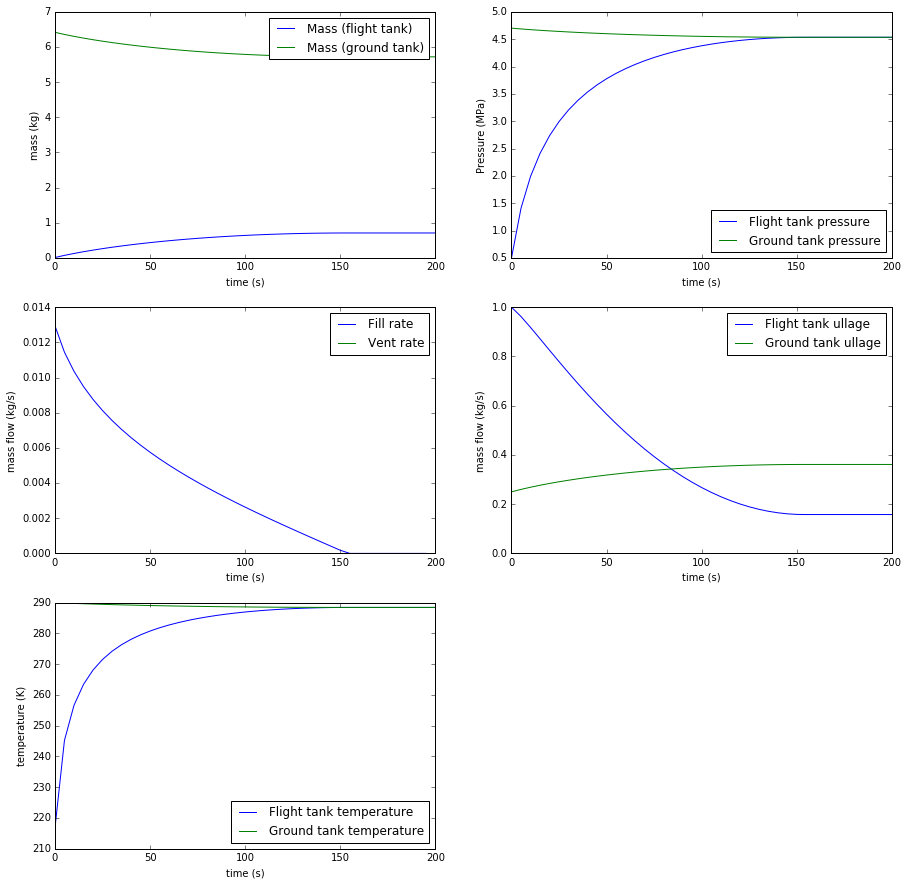

In [6]:
T_init_groundtank = 290.0
T_init_flighttank = tempFromSatPressure(5e5, 'NitrousOxide') # arbitrary (lowish) value.
V_groundtank = 10e-3          # 10 litre ground tank
ullage_init_groundtank = 0.25 # Ground tank starts out 3/4 full
V_flighttank = 1e-3           # 1 litre flight tank
ullage_init_flighttank = 1.0  # Starts out empty

fill_orifice_dia = 0.001 # metres
vent_orifice_dia = 0.000 # metres

C_d_liquid = 0.2 # suggested by Rick
C_d_gas = 0.8 # complete guess

timestep = 5.0
endtime = 200.0

run_sim_and_display(T_init_groundtank, T_init_flighttank, V_groundtank, ullage_init_groundtank, V_flighttank,\
                        ullage_init_flighttank, fill_orifice_dia, C_d_liquid, C_d_gas, timestep, endtime, \
                        legend_positions=[1,4,1,1,4], progressbar = False)

For a first guess, this scenario isn't terrible. The pressures in the ground and flight tanks equalise about 2.5 minutes into  the fill, at which time the flight tank is about 85% full of liquid nitrous oxide at a pressure of ~4.5 MPa. The gas flow back through the fill orifice when the fill line is depressurised is perhaps on the high end of what we're comfortable with - if it takes three seconds to depressurise and disconnect the line, then we'll have lost about 4% of the tank contents.

However, we'd prefer to have the option to completely fill the flight tank (this allows the "liquid coming out of the vent hole" criterion to be used, so we have a better idea of how full the tank is). This will need some sort of vent orifice.

## Example 2: Equal Vent and Fill Orifices

As a next-pass guess, let's try setting the vent and fill orifices both to ⌀0.5 mm. I don't expect this to work well, but let's see just how bad it gets.

Estimated gas backflow rate through fill orifice when fill line depressurised = 0.85 g/s
Final flight tank contents mass: 0.996 kg
Ground tank contents used: 1.449 kg
Final flight tank pressure: 1.818 MPa


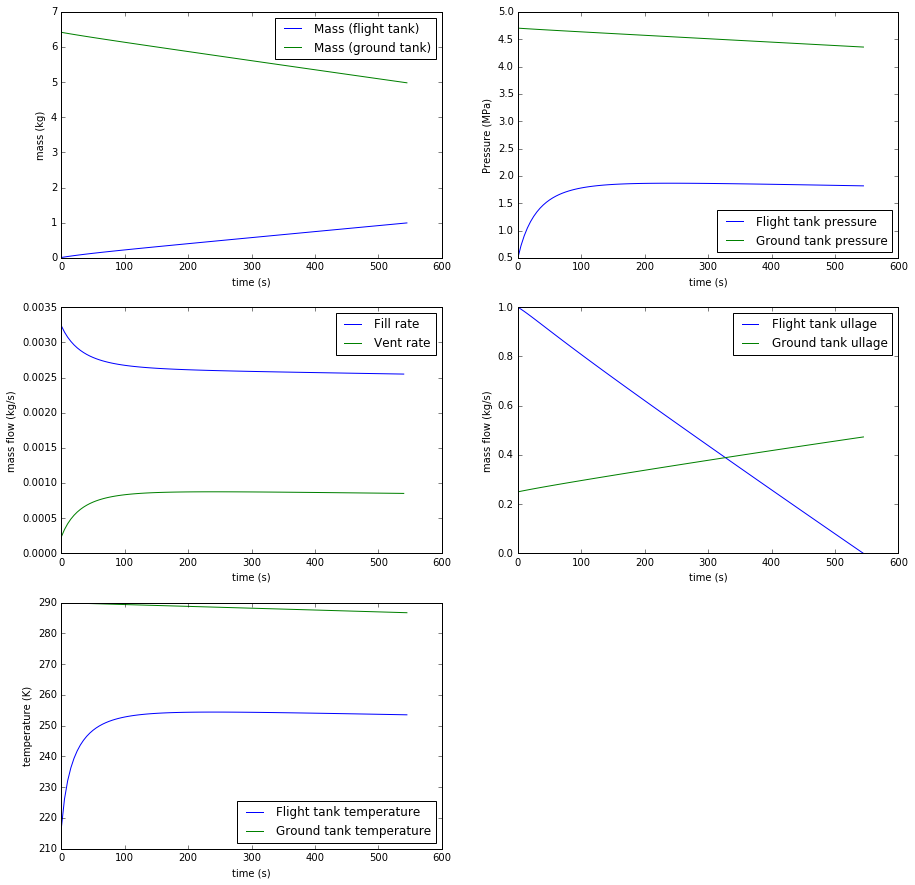

In [124]:
fill_orifice_dia = 0.0005 # metres
vent_orifice_dia = 0.0005 # metres

timestep = 5.0
endtime = 600.0

run_sim_and_display(T_init_groundtank, T_init_flighttank, V_groundtank, ullage_init_groundtank, V_flighttank,\
                        ullage_init_flighttank, fill_orifice_dia, C_d_liquid, C_d_gas, timestep, endtime, \
                        legend_positions=[1,4,1,1,4], progressbar = False)

Yeah, that's pretty bad.

The vent orifice is too large compared to the fill orifice, so the liquid nitrous in the flight tank has to boil off quite rapidly in order to keep up. This keeps it cold, so we end up with a flight tank full of cold liquid nitrous oxide. In practice it wouldn't be quite this bad - there'd be some heat transfer into the flight tank from ambient air - but it's tricky to estimate how much effect that would have. In principle you could wait for the tank to warm up to a point where the vapor pressure was high enough, but that might take a while, and I guess you'd have to monitor the pressure carefully and periodically vent the tank.

About a third of the nitrous taken from the ground tank is vented to atmosphere rather than going into the flight tank. This isn't a major issue, but it's slightly annoying.

Another potential issue is that the small fill orifice results in the tank taking nearly ten minutes to fill. On the plus side, it does actually fill all the way!

## Example 3: Small vent, medium-sized fill orifice

For a somewhat better fill-to-vent ratio, let's try setting the fill orifice to ⌀0.9 mm and the vent orifice to ⌀0.3 mm. The vent orifice will be somewhat tricky to drill.

Estimated gas backflow rate through fill orifice when fill line depressurised = 6.11 g/s
Final flight tank contents mass: 0.865 kg
Ground tank contents used: 0.966 kg
Final flight tank pressure: 3.808 MPa


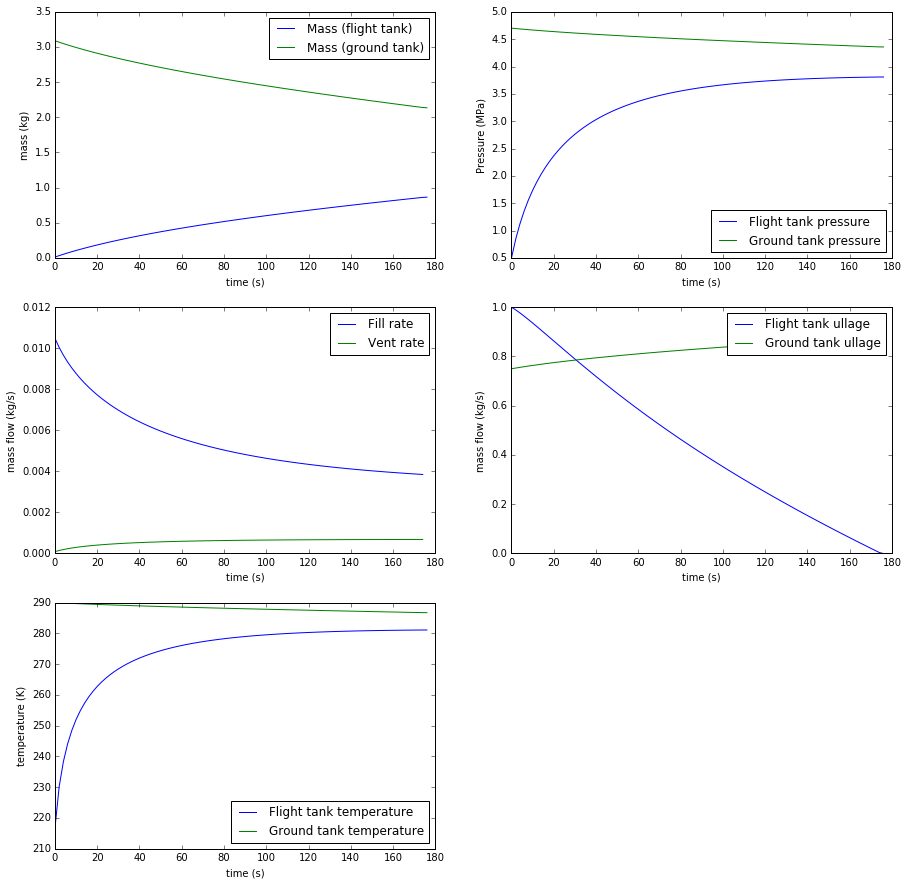

In [121]:
fill_orifice_dia = 0.0009 # metres
vent_orifice_dia = 0.0003 # metres

timestep = 2.0
endtime = 200.0

run_sim_and_display(T_init_groundtank, T_init_flighttank, V_groundtank, ullage_init_groundtank, V_flighttank,\
                        ullage_init_flighttank, fill_orifice_dia, C_d_liquid, C_d_gas, timestep, endtime, \
                        legend_positions=[1,4,1,1,4], progressbar = False)

That area ratio (9:1 fill:vent) isn't terrible under these assumptions. The tank doesn't take an absurdly long time to fill (about three minutes), the final flight tank pressure is pretty close to the ground tank pressure, and the rate at which nitrous oxide escapes from the fill orifice is also fairly low. However, manufacturing has become very difficult.

We could enlarge the vent orifice (and the fill orifice proportionally) until it was a more sensible size, but of course this would increase the rate at which gas escapes when the fill line is depressurised. I'm not sure what the highest rate we want to allow is.

One possible way around all of this would be (as Martin suggested at the weekend) to add some sort of very crude but lightweight "non-return feature" to the filling fitting. It wouldn't even need to seal perfectly, just reduce the effective area for backflow.

## Example 4: Sensitivity to Discharge Coefficient

One of the largest uncertainties in this model is the $C_d$ value of the fill orifice when two-phase nitrous oxide is flowing into the flight tank. As an illustration, if it is assumed that it can be set to an extremely high value of $C_d = 0.8$ (corresponding to an orifice length so short that bubbles had no time to form and that the single-phase incompressible approximation holds), then we could double the diameter of the vent orifice to ⌀0.6 mm - that is, change the fill:vent area ratio to 2.25 - while still getting the same conditions at the end of the fill (which would of course only take 1/4 of the time):

Estimated gas backflow rate through fill orifice when fill line depressurised = 6.24 g/s
Final flight tank contents mass: 0.860 kg
Ground tank contents used: 0.959 kg
Final flight tank pressure: 3.880 MPa


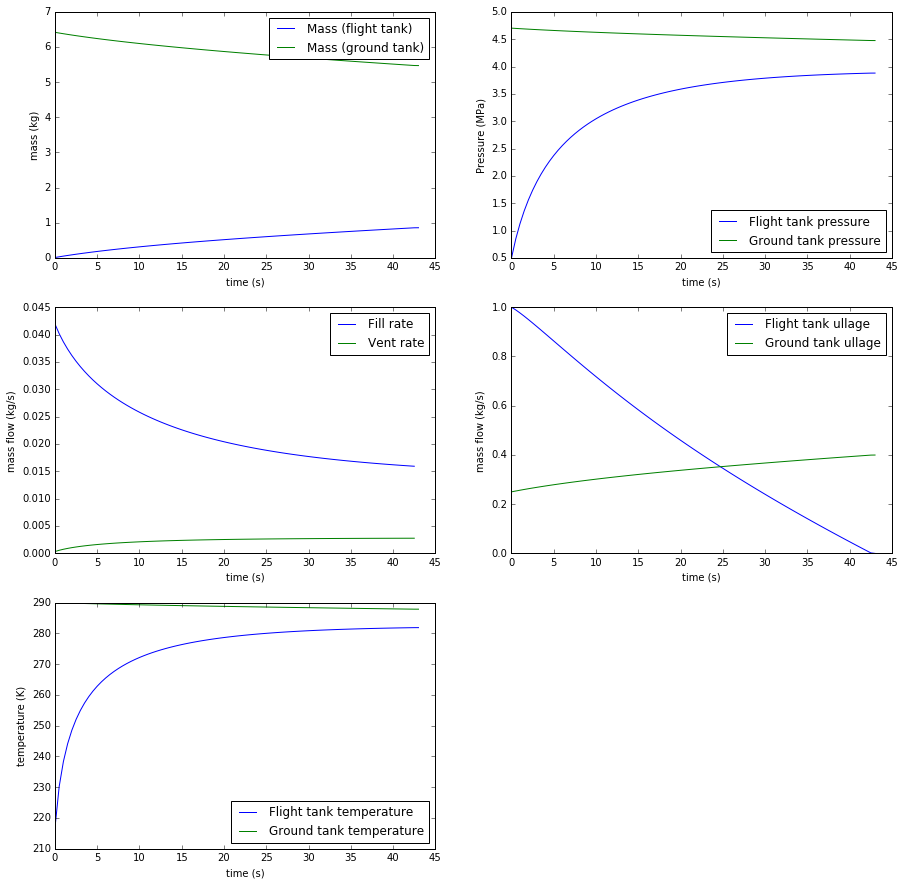

In [114]:
fill_orifice_dia = 0.0009 # metres
vent_orifice_dia = 0.0006 # metres

C_d_liquid = 0.8

timestep = 0.5
endtime = 50.0

run_sim_and_display(T_init_groundtank, T_init_flighttank, V_groundtank, ullage_init_groundtank, V_flighttank,\
                        ullage_init_flighttank, fill_orifice_dia, C_d_liquid, C_d_gas, timestep, endtime, \
                        legend_positions=[1,4,1,1,4], progressbar = False)

## Example 5: Sensitivity to ground tank temperature

Let's go back to Example 3 but assume it's a hot summer day, so the ground tank contents are at a balmy 300 Kelvin.

Estimated gas backflow rate through fill orifice when fill line depressurised = 8.34 g/s
Final flight tank contents mass: 0.793 kg
Ground tank contents used: 0.911 kg
Final flight tank pressure: 4.942 MPa


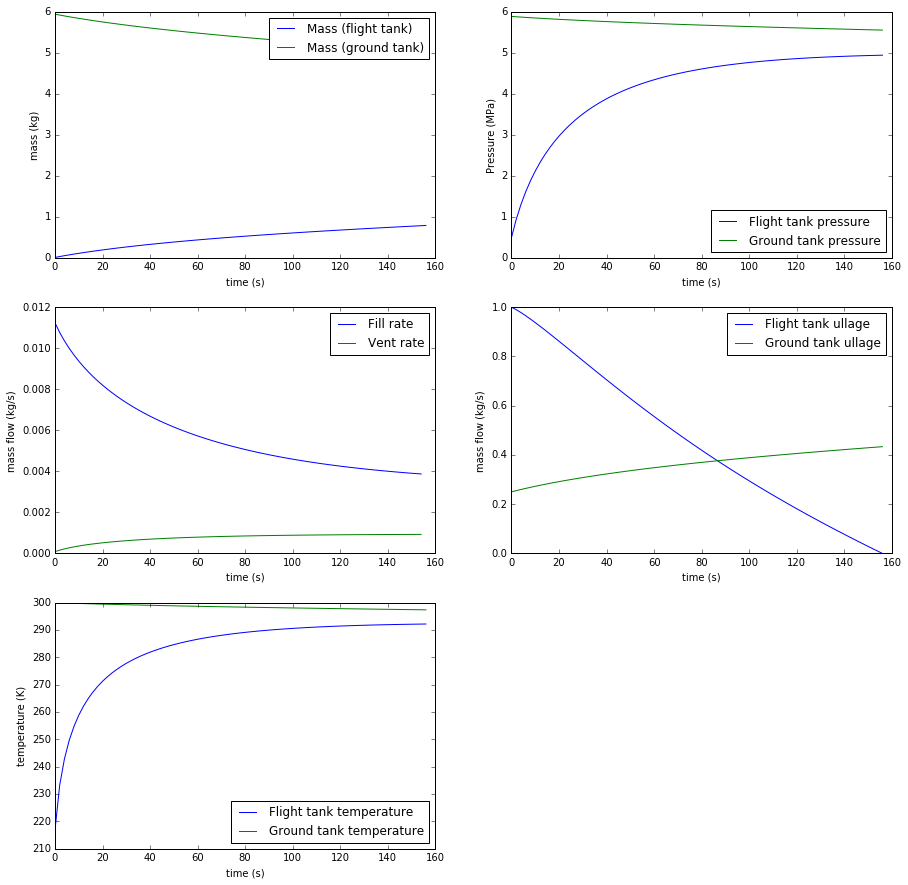

In [115]:
T_init_groundtank = 300.0

fill_orifice_dia = 0.0009 # metres
vent_orifice_dia = 0.0003 # metres

C_d_liquid = 0.2

timestep = 2.0
endtime = 200.0

run_sim_and_display(T_init_groundtank, T_init_flighttank, V_groundtank, ullage_init_groundtank, V_flighttank,\
                        ullage_init_flighttank, fill_orifice_dia, C_d_liquid, C_d_gas, timestep, endtime, \
                        legend_positions=[1,4,1,1,4], progressbar = False)

No big surprises there. Temperatures, pressures and densities all scale more-or-less proportionally with the properties under the warmer initial conditions.

## Example 6: (in)sensitivity to ground tank fill level

We're back in the land of Example 3, but the ground tank is close to being empty. This doesn't really make a difference.

Estimated gas backflow rate through fill orifice when fill line depressurised = 6.11 g/s
Final flight tank contents mass: 0.865 kg
Ground tank contents used: 0.966 kg
Final flight tank pressure: 3.808 MPa


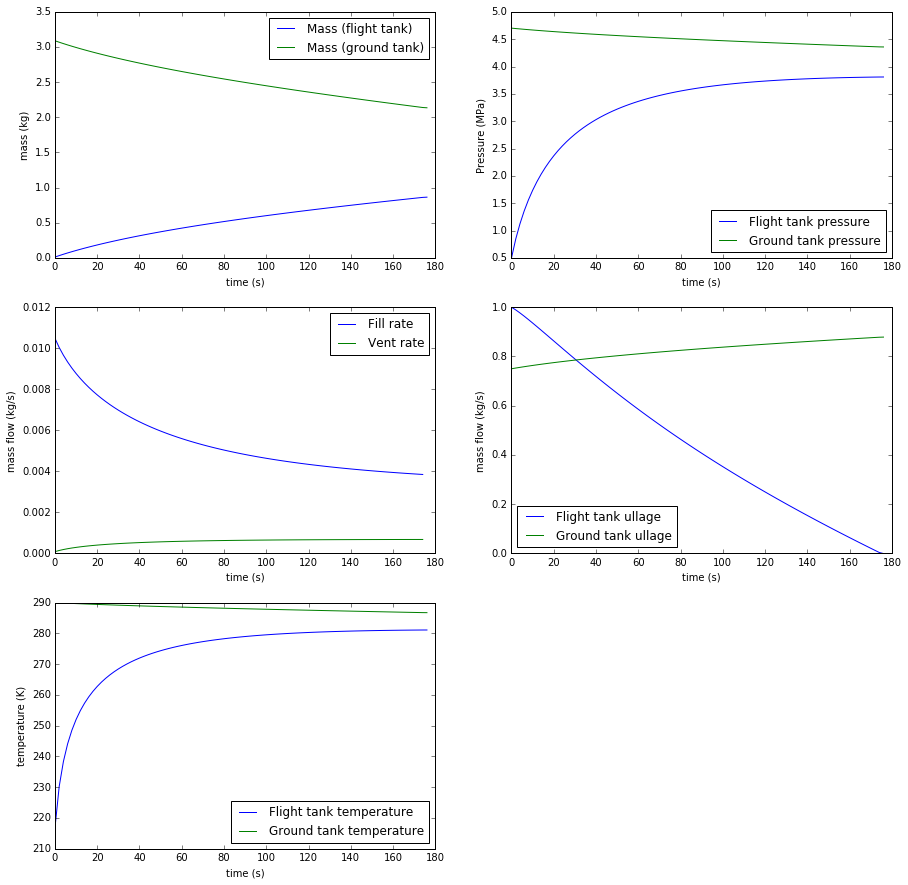

In [118]:
T_init_groundtank = 290.0
ullage_init_groundtank = 0.75 # Ground tank starts out 1/4 full

run_sim_and_display(T_init_groundtank, T_init_flighttank, V_groundtank, ullage_init_groundtank, V_flighttank,\
                        ullage_init_flighttank, fill_orifice_dia, C_d_liquid, C_d_gas, timestep, endtime, \
                        legend_positions=[1,4,1,3,4], progressbar = False)

## Conclusions

All numbers from this simulation should be taken with a pinch of salt, due to the highly-simplified nature of this model.

* Based on this model, it appears that a fill-to-vent orifice area ratio of 10-20 is desirable. If the fill orifice has an unexpectedly high discharge coefficient, this range may be as low as 3-5, but this would need experimental verificiation.
* There's a trade-off between vent orifice size and gas loss when the fill line is depressurised. Increasing the vent orifice size increases manufacturability but also increases gas loss through the fill orifice. I'm not sure what the highest acceptable gas loss rate is.
* Depending on the maximum acceptable gas loss rate and the smallest holes we can reliably drill, it may be necessary to explore other options, such as adding some movable element to the fill adapter to act as a lightweight non-return valve. This wouldn't even need to seal perfectly, just reduce the effective orifice area enough to be acceptable.